In [1]:
import os
import random
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import splitfolders

from IPython.display import display
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications.densenet import (DenseNet121,
                                                    preprocess_input)
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import (BatchNormalization, Dense,
                                     Dropout, Flatten, Input)
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Explore the COVID-19 radiography dataset

In [2]:
# Print the subdirectories of the dataset
DATASET_PATH = 'covid-19_radiography_dataset'
dir_list = os.listdir(DATASET_PATH)
print(dir_list)

['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']


In [5]:
# Print the number of images per subdirectory
num_of_images = []
for root, dirs, files in os.walk(DATASET_PATH):
    if root == DATASET_PATH: continue
    print('{}: {}'.format(os.path.basename(root), len(files)))
    num_of_images.append(len(files))

COVID: 3616
Lung Opacity: 6012
Normal: 10192
Viral Pneumonia: 1345


path: covid-19_radiography_dataset\COVID\COVID-2542.png
size: (299, 299)
mode: L
format: PNG


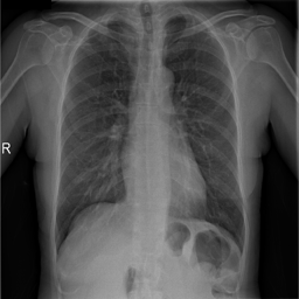

In [6]:
# Display a random image and print its path, size, mode, and format
SEED = 123
random.seed(SEED)
rand_img = Image.open(random.choice(glob(DATASET_PATH + '/**/*')))

print('path:', rand_img.filename)
print('size:', rand_img.size)
print('mode:', rand_img.mode)
print('format:', rand_img.format)
display(rand_img)

### Visualize the COVID-19 radiography dataset

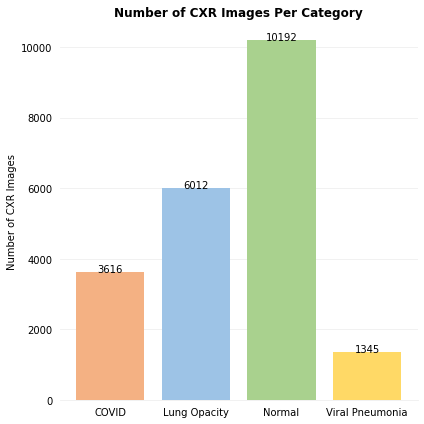

In [10]:
# Plot the number of images per subdirectory
x_coord = np.arange(len(dir_list))
colors = ['#f4b183', '#9dc3e6', '#a9d18e', '#ffd966']

fig, ax = plt.subplots(facecolor='white', figsize=(6,6))
ax.bar(x_coord, num_of_images, color=colors)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#EEEEEE')

ax.yaxis.grid(True, color='#EEEEEE')
ax.set_axisbelow(True)

plt.xticks(x_coord, dir_list)
ax.tick_params(bottom=False, left=False)

plt.title('Number of CXR Images Per Category', fontweight='bold')
plt.ylabel('Number of CXR Images')

for i in range(len(x_coord)):
    plt.text(i, num_of_images[i], num_of_images[i], ha='center')

plt.tight_layout()
plt.savefig('figures/bar_chart.png', dpi=200)
plt.show()

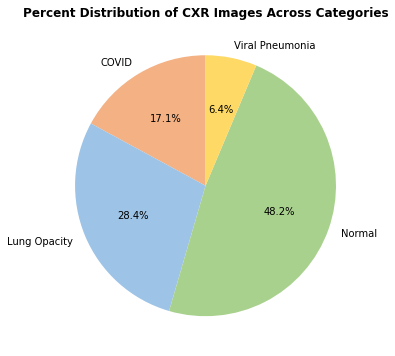

In [11]:
# Plot the percent distribution of images across subdirectories
plt.figure(facecolor='white', figsize=(6,6))
plt.pie(num_of_images,
        labels=dir_list,
        colors=colors,
        autopct='%.1f%%',
        startangle=90)
plt.title('Percent Distribution of CXR Images Across Categories', fontweight='bold')
plt.savefig('figures/pie_chart.png', dpi=200)
plt.show()

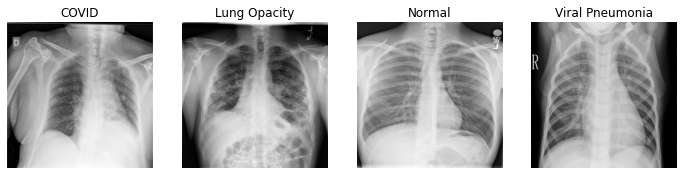

In [12]:
# Display random images, one from each category
plt.figure(facecolor='white', figsize=(12,3))
for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    path = random.choice(glob(DATASET_PATH + '/' + dir_list[i] + '/*'))
    plt.imshow(Image.open(path), cmap='gray')
    plt.title(dir_list[i])
    plt.axis('off')
plt.savefig('figures/random_images.png', dpi=200)
plt.show()

### Preprocess the COVID-19 radiography dataset

In [33]:
# Split the dataset folder into test, train, and val folders
OUTPUT_PATH = 'dataset_subsets'
if not os.path.exists(OUTPUT_PATH):
    splitfolders.ratio(DATASET_PATH, OUTPUT_PATH, SEED, (.7, .1, .2))

In [34]:
# Initialize the flow_from_directory args
IMG_DIMS = 224
TARGET_SIZE = (IMG_DIMS, IMG_DIMS)
COLOR_MODE = 'rgb'
CLASS_MODE = 'categorical'
BATCH_SIZE = 32

In [35]:
# Take the path to the train folder and generate batches of data
TRAIN_PATH = os.path.join(OUTPUT_PATH, 'train')
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.9, 1.1],
    zoom_range=[0.9, 1.1],
    horizontal_flip=True)
train_gen = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=TARGET_SIZE,
    color_mode=COLOR_MODE,
    class_mode=CLASS_MODE,
    batch_size=BATCH_SIZE,
    seed=SEED)

Found 14814 images belonging to 4 classes.


In [36]:
# Take the path to the val folder and generate batches of data
VAL_PATH = os.path.join(OUTPUT_PATH, 'val')
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)
val_gen = val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=TARGET_SIZE,
    color_mode=COLOR_MODE,
    class_mode=CLASS_MODE,
    batch_size=BATCH_SIZE,
    seed=SEED)

Found 2115 images belonging to 4 classes.


In [37]:
# Take the path to the train folder and generate batches of data
TEST_PATH = os.path.join(OUTPUT_PATH, 'test')
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)
test_gen = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=TARGET_SIZE,
    color_mode=COLOR_MODE,
    class_mode=CLASS_MODE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED)

Found 4236 images belonging to 4 classes.


### Analyze the COVID-19 radiography dataset

In [38]:
# Print the paths to the directories to read images from
print(train_gen.directory)
print(val_gen.directory)
print(test_gen.directory)

dataset_subsets\train
dataset_subsets\val
dataset_subsets\test


In [39]:
# Print the dictionary that maps class names to class indices
print(train_gen.class_indices)

{'COVID': 0, 'Lung Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


In [40]:
# Print the shapes of the first training batch tuple
images, labels = next(iter(train_gen))
print('images shape:', images.shape)  # (batch_size, *target_size, channels)
print('labels shape:', labels.shape)  # (batch_size, num_classes)

images shape: (32, 224, 224, 3)
labels shape: (32, 4)


### Build a customized DenseNet121 model

In [41]:
# Instantiate a Densenet121 architecture without the fully-connected layer
base_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_tensor=Input(shape=(IMG_DIMS, IMG_DIMS, 3)),
    input_shape=(IMG_DIMS, IMG_DIMS, 3))

In [42]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [43]:
# Build the modified DenseNet121 model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [44]:
# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 batch_normalization_3 (Batc  (None, 50176)            200704    
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 1024)              51381248  
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 1024)             4096      
 hNormalization)                                      

### Train the customized DenseNet121 model

In [45]:
# Define hyperparameters
EPOCHS = 25
ETA = 0.0001

In [46]:
# Select metrics
METRICS = ['categorical_accuracy', Precision(), Recall()]

In [47]:
# Compile the model
model.compile(optimizer=Adam(ETA),
              loss='categorical_crossentropy',
              metrics=METRICS)

In [48]:
# Create a learning rate scheduler callback
def scheduler(epoch):
    if epoch > 19:
        return ETA * 0.1
    else:
        return ETA
callback = LearningRateScheduler(scheduler)

In [49]:
# Estimate class weights for the unbalanced dataset
cls_wt = compute_class_weight(class_weight='balanced',
                              classes=np.unique(train_gen.labels),
                              y=train_gen.labels)
class_weight = {0: cls_wt[0], 1: cls_wt[1], 2: cls_wt[2], 3: cls_wt[3]}
print(class_weight)

{0: 1.4632556301856974, 1: 0.8801093155893536, 2: 0.5191337258200168, 3: 3.9357066950053134}


In [50]:
# Train the model
history = model.fit(train_gen,
                    epochs=EPOCHS,
                    callbacks=callback,
                    validation_data=val_gen,
                    class_weight=class_weight)

Epoch 1/25
463/463 [==============================] - 1318s 3s/step - loss: 0.4736 - categorical_accuracy: 0.7837 - precision_1: 0.8192 - recall_1: 0.7441 - val_loss: 0.3100 - val_categorical_accuracy: 0.8913 - val_precision_1: 0.9050 - val_recall_1: 0.8780 - lr: 1.0000e-04
Epoch 2/25
463/463 [==============================] - 1468s 3s/step - loss: 0.3274 - categorical_accuracy: 0.8502 - precision_1: 0.8643 - recall_1: 0.8311 - val_loss: 0.2613 - val_categorical_accuracy: 0.9102 - val_precision_1: 0.9160 - val_recall_1: 0.9069 - lr: 1.0000e-04
Epoch 3/25
463/463 [==============================] - 1291s 3s/step - loss: 0.2832 - categorical_accuracy: 0.8661 - precision_1: 0.8783 - recall_1: 0.8541 - val_loss: 0.2527 - val_categorical_accuracy: 0.9139 - val_precision_1: 0.9198 - val_recall_1: 0.9050 - lr: 1.0000e-04
Epoch 4/25
463/463 [==============================] - 1282s 3s/step - loss: 0.2534 - categorical_accuracy: 0.8770 - precision_1: 0.8852 - recall_1: 0.8658 - val_loss: 0.2614 -

### Visualize the training results

In [51]:
def plot_metric_history(metric, val_metric, y_label, title):
    """
    Plots a training history metric.

    :param metric: the metric key
    :param val_metric: the validation metric key
    :param y_label: the y-axis label
    :param title: the title
    :return: None
    """
    plt.figure(facecolor='white', figsize=(8, 6))
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.ylabel(y_label)
    plt.xlabel('epoch')
    plt.title(title)
    plt.legend(['training', 'validation'])
    plt.savefig('figures/' + y_label + '.png', dpi=200)
    plt.show()

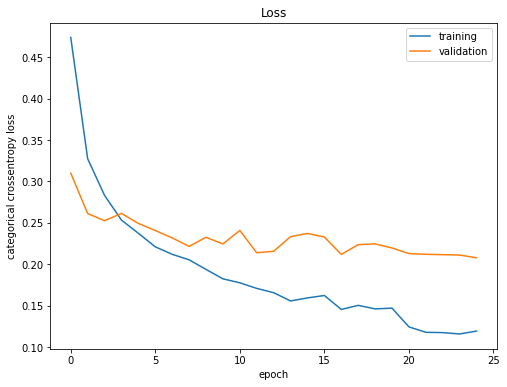

In [52]:
# Visualize loss history
plot_metric_history(metric='loss',
                    val_metric='val_loss',
                    y_label='categorical crossentropy loss',
                    title='Loss')

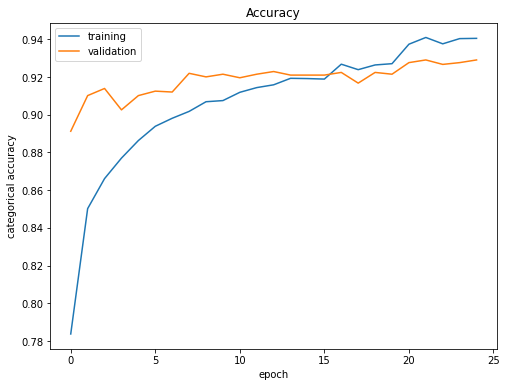

In [53]:
# Visualize accuracy history
plot_metric_history(metric='categorical_accuracy',
                    val_metric='val_categorical_accuracy',
                    y_label='categorical accuracy',
                    title='Accuracy')

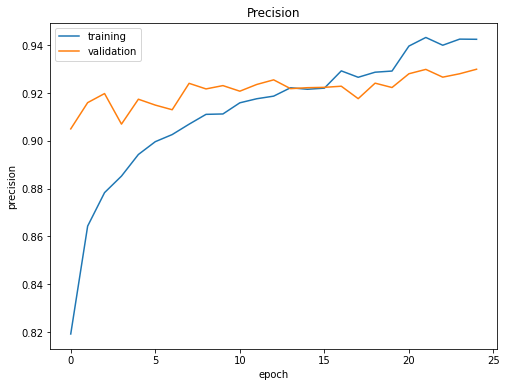

In [55]:
# Visualize precision history
plot_metric_history(metric='precision_1',
                    val_metric='val_precision_1',
                    y_label='precision',
                    title='Precision')

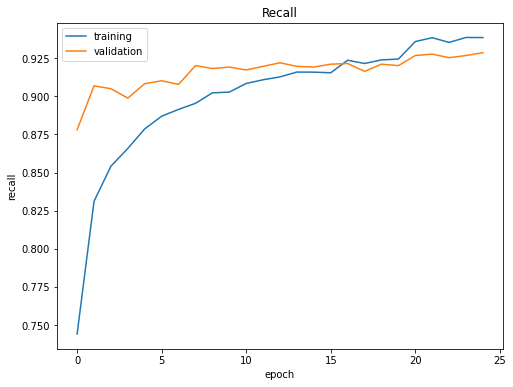

In [56]:
# Visualize recall history
plot_metric_history(metric='recall_1',
                    val_metric='val_recall_1',
                    y_label='recall',
                    title='Recall')

### Evaluate the customized DenseNet121 model

In [57]:
# Print metrics values for the model in test mode
result = model.evaluate(test_gen)
dict(zip(model.metrics_names, result))

133/133 [==============================] - 319s 2s/step - loss: 0.1965 - categorical_accuracy: 0.9356 - precision_1: 0.9362 - recall_1: 0.9348


{'loss': 0.19648154079914093,
 'categorical_accuracy': 0.9355524182319641,
 'precision_1': 0.936170220375061,
 'recall_1': 0.9348441958427429}

In [58]:
# Generate output predictions for the test input samples
predictions = model.predict(test_gen)

133/133 [==============================] - 325s 2s/step


In [59]:
# Initialize true and predicted label values
y_true = test_gen.labels
y_pred = np.argmax(predictions, axis=1)

In [60]:
# Build a text report showing the main classification metrics
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       724
           1       0.92      0.89      0.90      1203
           2       0.92      0.95      0.94      2039
           3       0.98      0.97      0.98       270

    accuracy                           0.94      4236
   macro avg       0.95      0.94      0.95      4236
weighted avg       0.94      0.94      0.94      4236



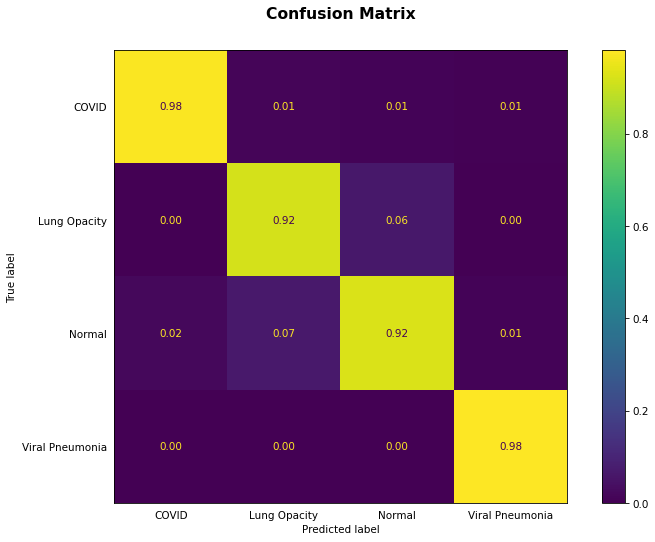

In [66]:
# Plot a confusion matrix given true and predicted labels
fig, ax = plt.subplots(facecolor='white', figsize=(12, 8), dpi=75)
fig = ConfusionMatrixDisplay.from_predictions(y_true,
                                              y_pred,
                                              display_labels=test_gen.class_indices,
                                              include_values=True,
                                              normalize='pred',
                                              values_format='.2f',
                                              cmap='viridis',
                                              ax=ax)
plt.tick_params(left=False, bottom=False)
plt.title('Confusion Matrix', fontsize=15, fontweight='bold', pad=30)
plt.savefig('figures/confusion_matrix.png', dpi=200)
plt.show()